In [1]:
%matplotlib widget

In [2]:
%%html
<style>
.cell-output-ipywidget-background {
   background-color: transparent !important;
}
.jp-OutputArea-output {
   background-color: transparent;
}  
</style>

In [3]:
import os
import sys
import numpy as np
import pandas as pd
import tqdm
import matplotlib.pyplot as plt

root = os.path.dirname(os.path.dirname(os.path.realpath('__file__')))
sys.path.insert(0, os.path.join(root, 'src'))

from detectors import detectors_dir
from models import models_dir


In [4]:
import cmasher as cmr
cmap_pd = cmr.get_sub_cmap('brg', 0.5, 1)
cmap_auc = cmr.get_sub_cmap('brg', 0, 1)

## Setup


In [5]:
anomalies_labels = [
    'GWN', 
    'Impulse', 
    'Step', 
    'Constant',  
    'GNN',
    'MixingGWN', 
    'MixingConstant',
    'SpectralAlteration', 
    'PrincipalSubspaceAlteration',
    'TimeWarping',
    'Clipping',
    'Dead-Zone'
]

feature_detectors = ['MD', 'TV', 'ZC', 'pk-pk', 'energy']

results_folder = '/srv/newpenny/dnn-cs/tsoc/results/TSOC/detection'

# Detector-specific configuration
# kernel = "rbf"   
kernel = "poly"    
nu_list = [0.001, 0.01, 0.1]
neighbors_list = [5, 10, 20, 50]
estimators_list = [5, 10, 20, 50, 100, 200, 500, 1000]

k_list = [1, 2, 4, 8, 16, 24, 32, 46]
order_list = [1, 2, 4, 8, 16, 24]

seed_train_list = [0, 1, 2, 3, 4]
opt_list = ['adam', 'sgd']
bs_list = [32, 64, 128]
alpha_list = [0.001, 0.01, 0.1, 0.25, 0.4, 0.5, 0.6, 0.75, 0.9, 0.99]
# alpha_list = [0.001, 0.01, 0.1, 0.4, 0.5, 0.75, 0.9, 0.99]
min_delta_list = [1e-4, 1e-5]

# Anomalies configuration
seed_ko = 0
N_test = 10_000
# delta_list = [0.01, 0.02, 0.05, 0.1, 0.2, 0.5]
delta_list = [0.001, 0.002, 0.005,0.01, 0.02, 0.05, 0.1, 0.2, 0.5, 0.8]

m_list = [32, 48, 64]
mode_list = ['standard', 'rakeness']
ort_list = [True, False]
seed_mat_list = []

# Fixed parameters
m = 48
mode = 'rakeness'
orthogonal = True
seed_mat = 30808
seed_train = 0
opt = 'adam'
min_delta = 1e-5

In [6]:
## plot P_D vs delta for different detector's parameters
def plot_performance(data, parameters, parameter_label):
    handles = []
    labels = []
    fig, ax = plt.subplots(2, len(anomalies_labels), figsize=(21, 5), sharey=True, sharex=True)
    for parameter in parameters:
        for j, anomaly in enumerate(anomalies_labels):
            data_ = data.xs(key=parameter, level=parameter_label)[anomaly]
            ax[0, j].set(title=anomaly)
            # ax[0, j].plot(data_.index, 1- data_, label=f'{parameter_label}={parameter}')
            ax[0, j].plot(data_.index, 1- data_)
            # ax[1, j].plot(data_.index, 0.5 + abs(data_.values-0.5), label=f'{parameter_label}={parameter}')
            handle, = ax[1, j].plot(data_.index, 0.5 + abs(data_.values-0.5))
            ax[1, j].set(xlabel='$\delta$')
            if j == 0:
                handles.append(handle)
                labels.append(f'{parameter_label}={parameter}')
    ax[0, 0].set(ylabel='1-AUC')
    ax[1, 0].set(ylabel='$P_D$')

    fig.legend(
        handles=handles,
        labels=labels,
        loc='upper center',
        ncol=len(parameters),
        fontsize=9,
        bbox_to_anchor=(0.5, 1.0),  # Adjust position relative to the figure
    )
    fig.tight_layout(rect=[0, 0, 1, 0.95])


In [7]:
# identify all trained detecors
trained_detectors = os.listdir(detectors_dir)
trained_detectors = [trained_detector for trained_detector in trained_detectors if not 'seedselect' in trained_detector]

In [8]:
# parameters of the detector from its name
def parse_detector_parameters(detector_name):
    detector_name = detector_name.split('.pkl')[0]
    params = detector_name.split('_')
    param_dict = {}
    param_dict['detector'] = params[0]
    for param in params[1:]:
        key, value = param.split('=')
        # Attempt to convert to int, float, or keep as string
        if value.isdigit():
            param_dict[key] = int(value)
        else:
            try:
                param_dict[key] = float(value)
            except ValueError:
                # Special case for booleans
                if value.lower() in ['true', 'false']:
                    param_dict[key] = value.lower() == 'true'
                else:
                    param_dict[key] = value

    return param_dict

In [9]:
def load_results(detector_label, parameter_label):
    index = pd.MultiIndex.from_product(
    [delta_list, m_list, mode_list, ort_list, seed_mat_list, estimators_list],
      names=['delta', 'm', 'mode', 'ort', 'seedmat', parameter_label])

    results = pd.DataFrame(index=index, columns=anomalies_labels, dtype=np.float64)
    results.columns.name = 'anomalies'
    for delta in delta_list:
        for trained_detector in trained_detectors:
            params = parse_detector_parameters(trained_detector)
            if not params['detector'] == detector_label:
                continue
            if not params['seedmat'] == seed_mat:
                continue
            trained_detector = f"{trained_detector.split('.pkl')[0]}"
            results_path = os.path.join(results_folder, f'AUC_detector={trained_detector}_delta={delta}_seedko={seed_ko}.pkl')
            if os.path.exists(results_path):
                result_ = pd.read_pickle(results_path)
                results.loc[delta, params['m'], params['mode'], params['ort'], params['seedmat'], params[parameter_label]] = result_
    # results['mean'] = results.mean(axis=-1)
    return results


## Isolation Forest

In [10]:
detector_label = 'IF'
parameter_label = 'estimators'
results_IF = load_results(detector_label, parameter_label)

In [11]:
(1-results_IF).style.background_gradient(cmap=cmap_auc, vmin=0.5, vmax=1)

In [12]:
results_IF_PD = 0.5 + np.abs(results_IF-0.5)
results_IF_PD['mean'] = results_IF_PD.mean(axis=1)
results_IF_PD.style.background_gradient(cmap=cmap_pd, vmin=0.5, vmax=1)

In [13]:
results_IF_avg = results_IF_PD.groupby('estimators').mean()
estimators = results_IF_avg['mean'].idxmax()
print(f'Best # estimators = {estimators}')
results_IF_avg.style.background_gradient(cmap=cmap_pd, vmin=0.5, vmax=1)

Best # estimators = 500


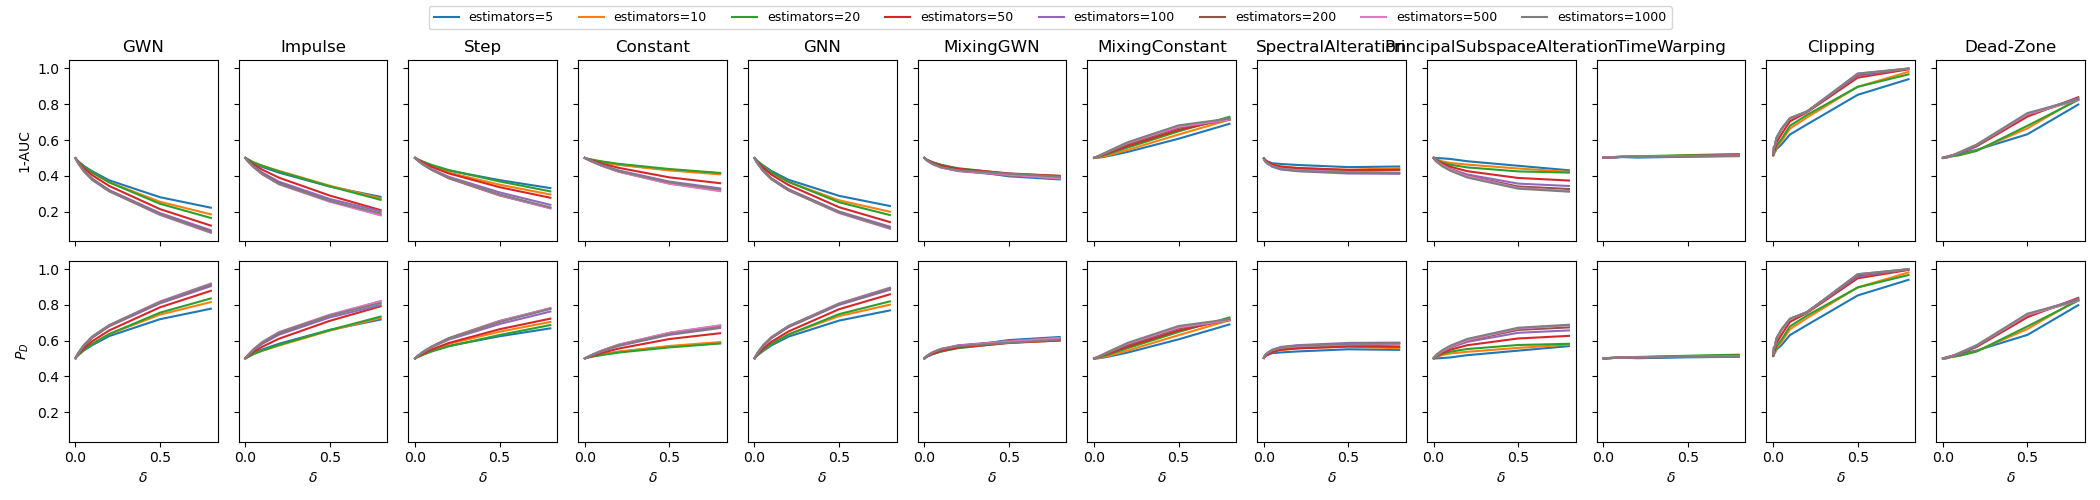

In [14]:
data_IF = results_IF.loc[:, m, mode, orthogonal, seed_mat]
plot_performance(data_IF, estimators_list, 'estimators')

## LOF

In [15]:
detector_label = 'LOF'
parameter_label = 'neighbors'
results_LOF = load_results(detector_label, parameter_label)

In [16]:
(1-results_LOF).style.background_gradient(cmap=cmap_auc, vmin=0, vmax=1)

In [17]:
results_LOF_PD = 0.5 + np.abs(results_LOF-0.5)
results_LOF_PD['mean'] = results_LOF_PD.mean(axis=1)
results_LOF_PD.style.background_gradient(cmap=cmap_pd, vmin=0.5, vmax=1)

In [18]:
results_LOF_avg = results_LOF_PD.groupby('neighbors').mean()
neighbors = results_LOF_avg['mean'].idxmax()
print(f'Best # neighbors = {neighbors}')
results_LOF_avg.style.background_gradient(cmap=cmap_pd, vmin=0.5, vmax=1)

Best # neighbors = 10


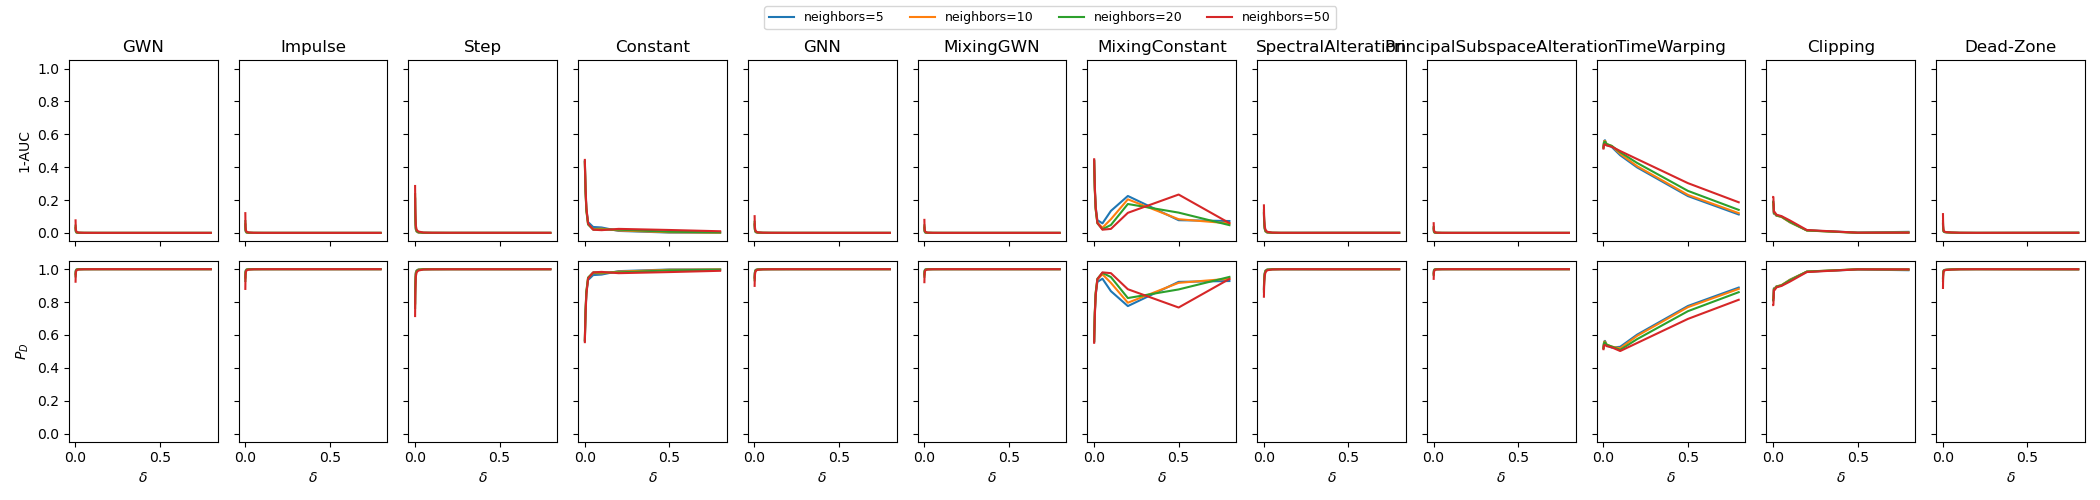

In [19]:
data_LOF = results_LOF.loc[:, m, mode, orthogonal, seed_mat]
plot_performance(data_LOF, neighbors_list, 'neighbors')

## OCSVM

In [20]:
detector_label = 'OCSVM'
parameter_label = 'nu'
results_OCSVM = load_results(detector_label, parameter_label)

In [ ]:
(1-results_OCSVM).style.background_gradient(cmap=cmap_auc, vmin=0, vmax=1)

In [22]:
# (0.5 + np.abs(results_OCSVM-0.5)).style.background_gradient(cmap=cmap_pd, vmin=0.5, vmax=1)
results_OCSVM_PD = 0.5 + np.abs(results_OCSVM-0.5)
results_OCSVM_PD['mean'] = results_OCSVM_PD.mean(axis=1)
results_OCSVM_PD.style.background_gradient(cmap=cmap_pd, vmin=0.5, vmax=1)

In [23]:
results_OCSVM_avg = results_OCSVM_PD.groupby('nu').mean()
nu = results_OCSVM_avg['mean'].idxmax()
print(f'Best nu = {nu}')
results_OCSVM_avg.style.background_gradient(cmap=cmap_pd, vmin=0.5, vmax=1)

Best nu = 0.1


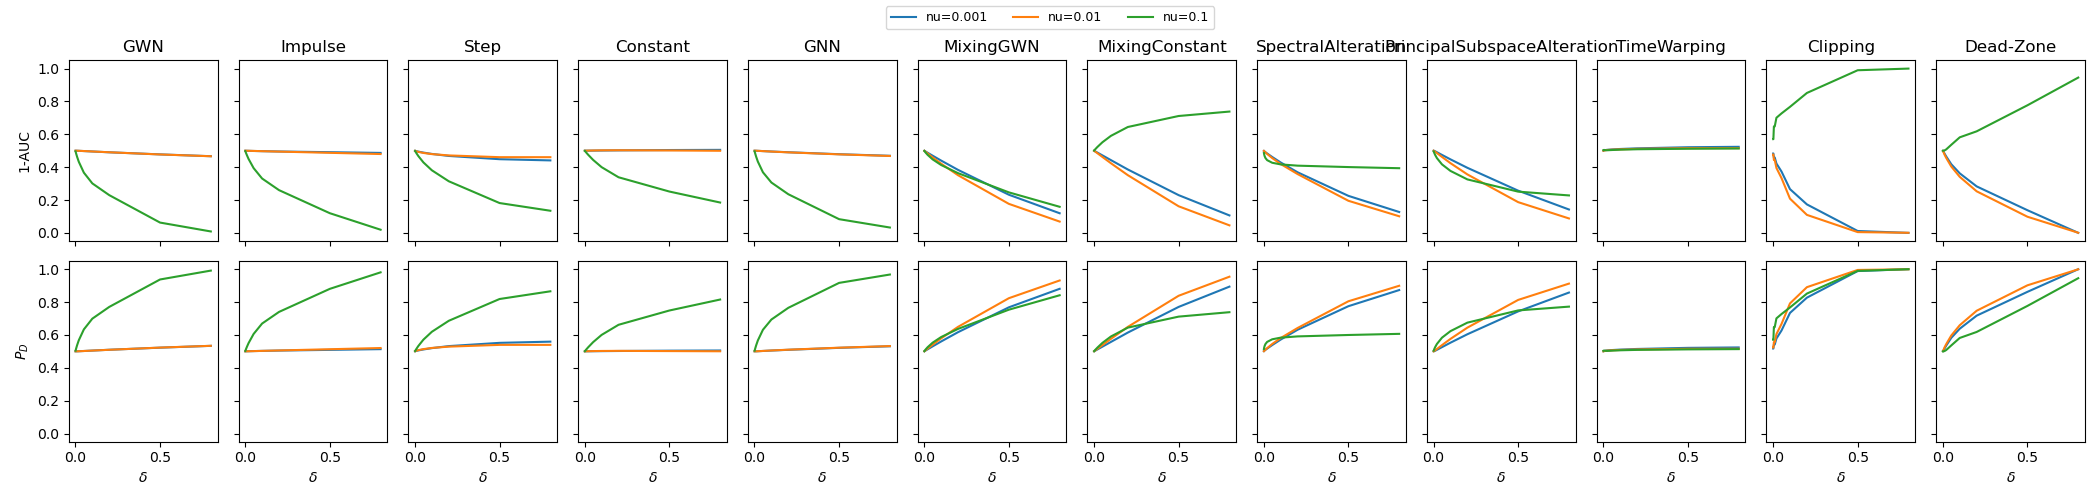

In [24]:
data_OCSVM = results_OCSVM.loc[:, m, mode, orthogonal, seed_mat]
plot_performance(data_OCSVM, nu_list, 'nu')

## SPE

In [25]:
detector_label = 'SPE'
parameter_label = 'k'
results_SPE = load_results(detector_label, parameter_label)

In [ ]:
(1-results_SPE).style.background_gradient(cmap=cmap_auc, vmin=0, vmax=1)

In [ ]:
results_SPE_PD = 0.5 + np.abs(results_SPE-0.5)
results_SPE_PD['mean'] = results_SPE_PD.mean(axis=1)
results_SPE_PD.style.background_gradient(cmap=cmap_pd, vmin=0.5, vmax=1)

In [28]:
results_SPE_avg = results_SPE_PD.groupby('k').mean()
k_SPE = results_SPE_avg['mean'].idxmax()
print(f'Best k = {k_SPE}')
results_SPE_avg.style.background_gradient(cmap=cmap_pd, vmin=0.5, vmax=1)

Best k = 32


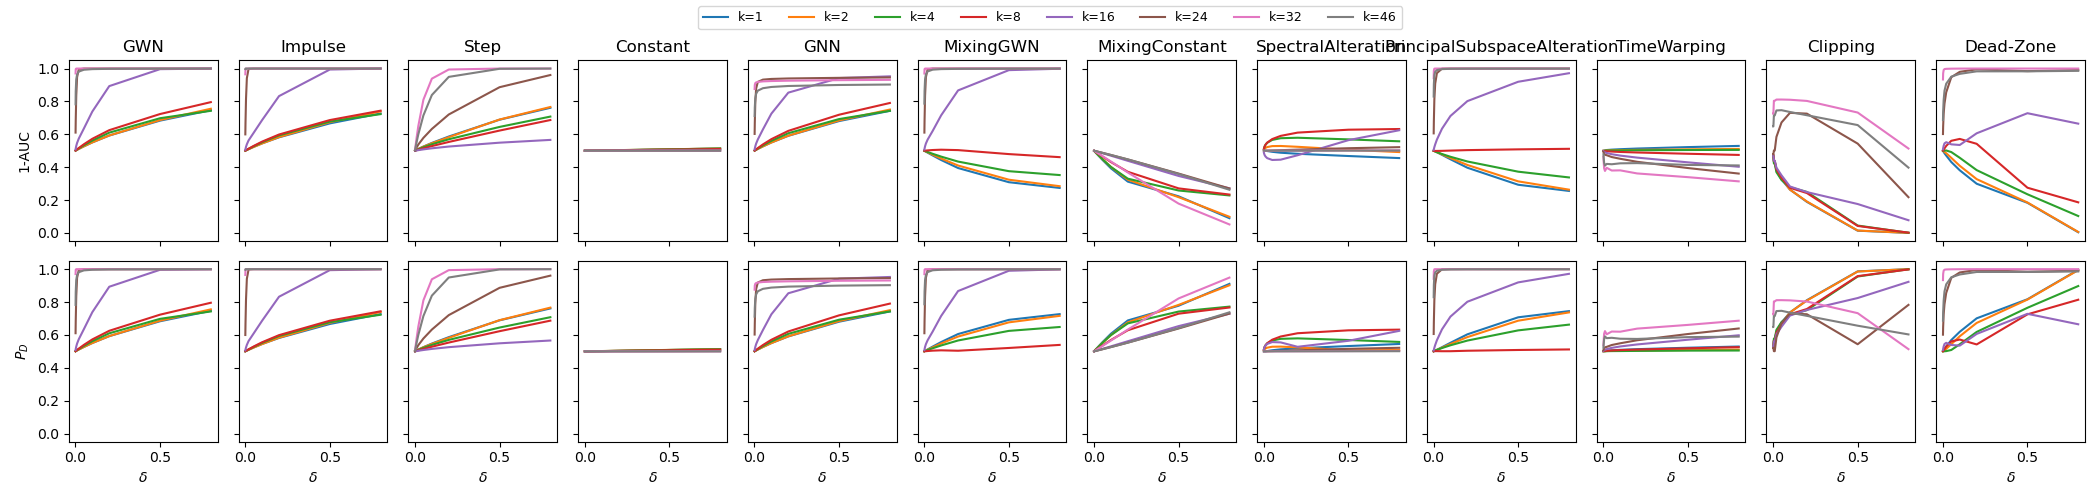

In [29]:
data_SPE = results_SPE.loc[:, m, mode, orthogonal, seed_mat]
plot_performance(data_SPE, k_list, 'k')

## T2

In [30]:
detector_label = 'T2'
parameter_label = 'k'
results_T2 = load_results(detector_label, parameter_label)

In [ ]:
(1-results_T2).style.background_gradient(cmap=cmap_auc, vmin=0, vmax=1)

In [32]:
results_T2_PD = 0.5 + np.abs(results_T2-0.5)
results_T2_PD['mean'] = results_T2_PD.mean(axis=1)
results_T2_PD.style.background_gradient(cmap=cmap_pd, vmin=0.5, vmax=1)

In [33]:
results_T2_avg = results_T2_PD.groupby('k').mean()
k_T2 = results_T2_avg['mean'].idxmax()
print(f'Best k = {k_T2}')
results_T2_avg.style.background_gradient(cmap=cmap_pd, vmin=0.5, vmax=1)

Best k = 46


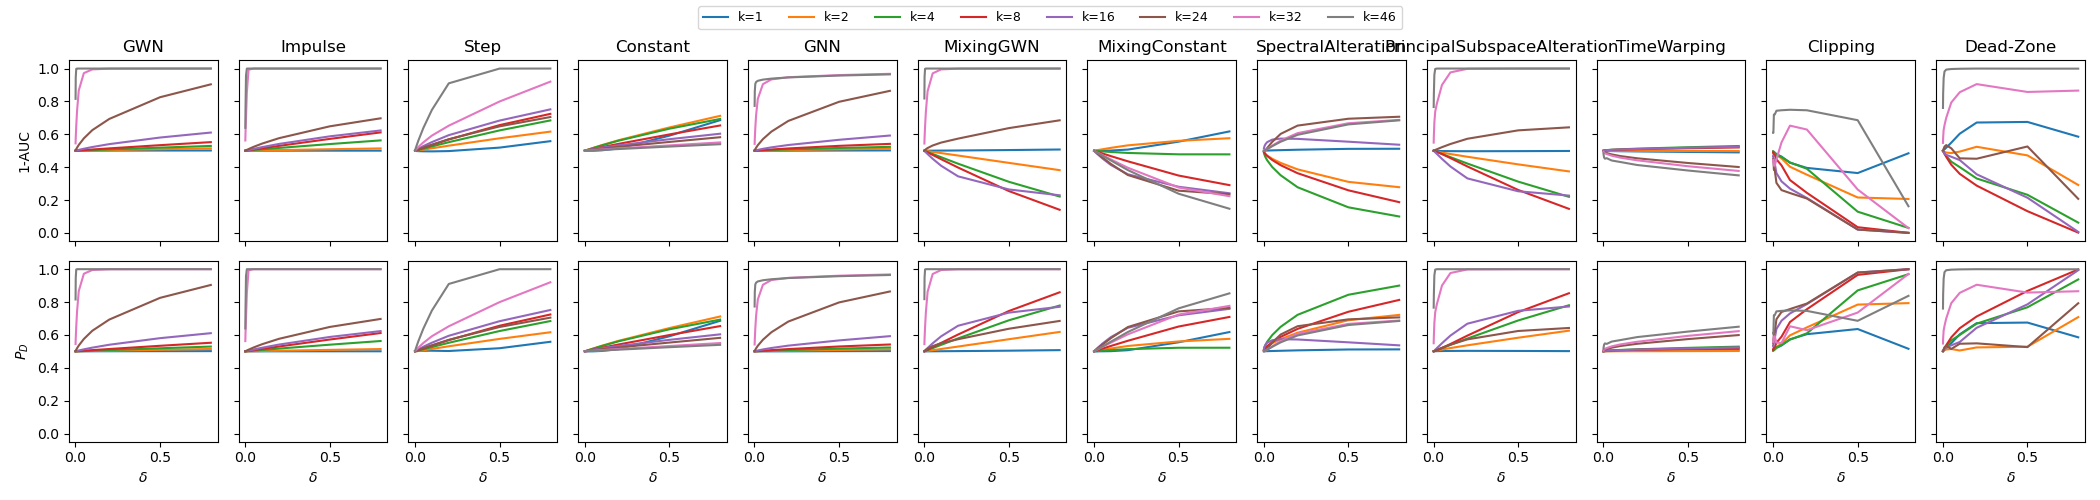

In [34]:
data_T2 = results_T2.loc[:, m, mode, orthogonal, seed_mat]
plot_performance(data_T2, k_list, 'k')

## AR

In [35]:
detector_label = 'AR'
parameter_label = 'order'
results_AR = load_results(detector_label, parameter_label)

In [ ]:
(1-results_AR).style.background_gradient(cmap=cmap_auc, vmin=0, vmax=1)

In [37]:
results_AR_PD = 0.5 + np.abs(results_AR-0.5)
results_AR_PD['mean'] = results_AR_PD.mean(axis=1)
results_AR_PD.style.background_gradient(cmap=cmap_pd, vmin=0.5, vmax=1)

In [38]:
results_AR_avg = results_AR_PD.groupby('order').mean()
order = results_AR_avg['mean'].idxmax()
print(f'Best order = {order}')
results_AR_avg.style.background_gradient(cmap=cmap_pd, vmin=0.5, vmax=1)

Best order = 24


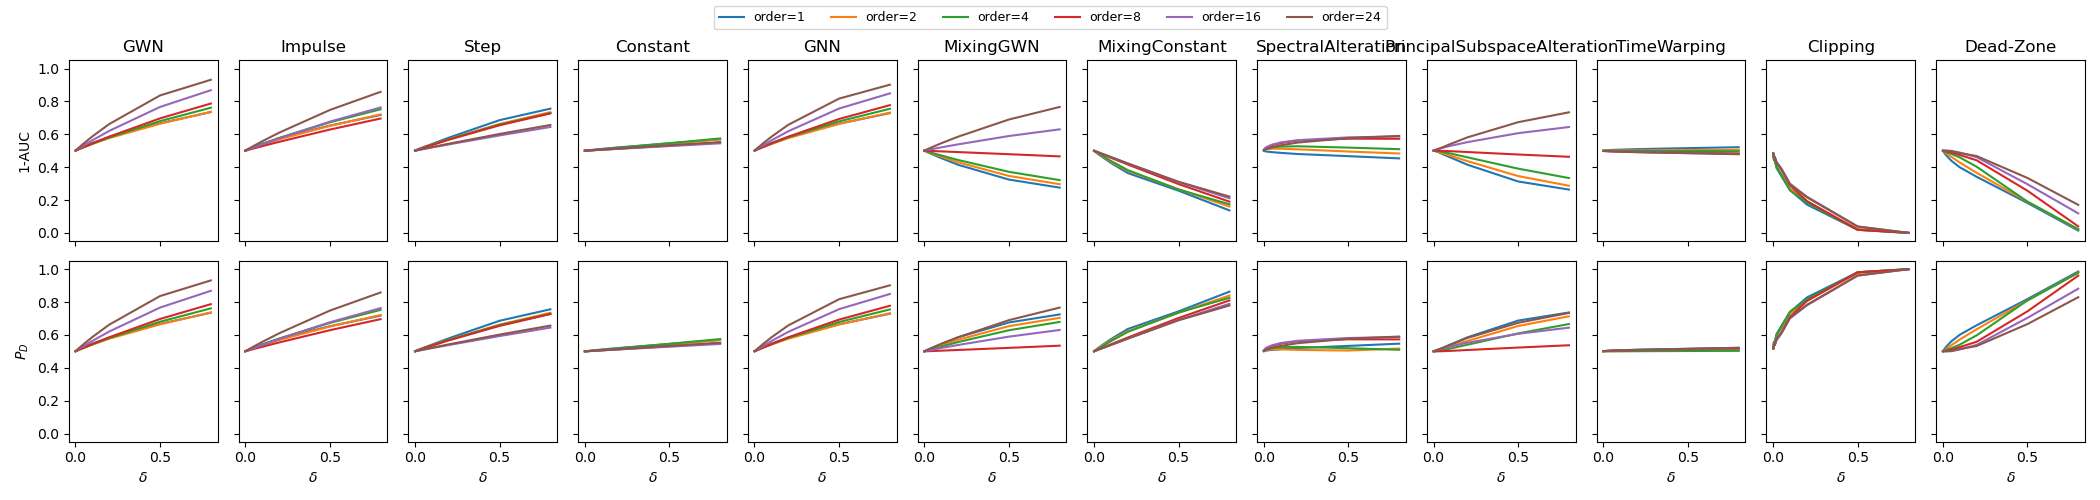

In [39]:
data_AR = results_AR.loc[:, m, mode, orthogonal, seed_mat]
plot_performance(data_AR, order_list, 'order')

## Feature-based

In [40]:
results_FB = []
for detector_label in feature_detectors:
  result = load_results(detector_label, 'detector')
  results_FB.append(result)
results_FB = pd.concat(results_FB)

In [ ]:
(1-results_FB).style.background_gradient(cmap=cmap_auc, vmin=0, vmax=1)

In [42]:
results_FB_PD = 0.5 + np.abs(results_FB-0.5)
results_FB_PD['mean'] = results_FB_PD.mean(axis=1)
results_FB_PD.style.background_gradient(cmap=cmap_pd, vmin=0.5, vmax=1)

In [43]:
results_FB_avg = results_FB_PD.groupby('detector').mean()
detector = results_FB_avg['mean'].idxmax()
print(f'Best detector = {detector}')
results_FB_avg.style.background_gradient(cmap=cmap_pd, vmin=0.5, vmax=1)

Best detector = MD


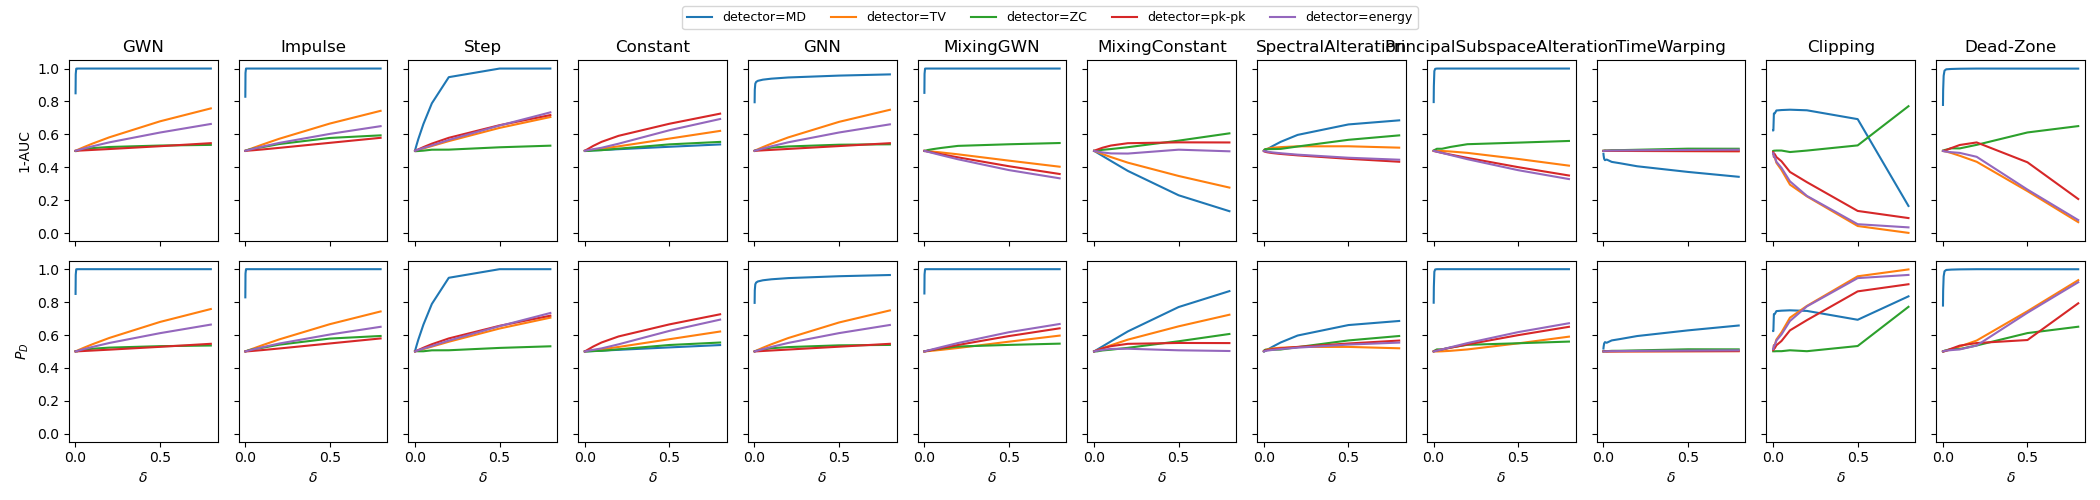

In [44]:
data_FB = results_FB.loc[:, m, mode, orthogonal, seed_mat, :]
plot_performance(data_FB, feature_detectors, 'detector')

# Autoencoder

In [45]:
def parse_neural_parameters(model_name, detector_type='TSOC'):
    model_name = model_name.split('.pth')[0]
    model_name = model_name.split(f'{detector_type}-')[1]
    params = model_name.split('_')
    param_dict = {}
    for param in params:
        key, value = param.split('=')
        # Attempt to convert to int, float, or keep as string
        if value.isdigit():
            param_dict[key] = int(value)
        else:
            try:
                param_dict[key] = float(value)
            except ValueError:
                # Special case for booleans
                if value.lower() in ['true', 'false']:
                    param_dict[key] = value.lower() == 'true'
                else:
                    param_dict[key] = value

    return param_dict

In [46]:
def load_ae_based_results(detector_mode, trained_models):
    index = pd.MultiIndex.from_product(
    [delta_list, m_list, mode_list, ort_list, seed_mat_list, seed_train_list, opt_list, bs_list, min_delta_list],
      names=['delta', 'm', 'mode', 'ort', 'seedmat', 'seedtrain', 'opt', 'bs', 'mind'])

    results = pd.DataFrame(index=index, columns=anomalies_labels, dtype=np.float64)
    results.columns.name = 'anomalies'
    for delta in delta_list:
        for alpha in alpha_list:
            for trained_model in trained_models:
                params = parse_neural_parameters(trained_model, 'AE')
                # if not params['seedmat'] == 88219:
                #     continue
                trained_model = f"{trained_model.split('.pth')[0]}"
                if mode == 'rakeness':
                    trained_model = trained_model.split('_')[:-2]
                    trained_model = '_'.join(trained_model)   
                results_subfolder = [file for file in os.listdir(os.path.join(results_folder)) if f'AE_{mode}' in file][0]
                results_path = os.path.join(results_folder, results_subfolder, detector_mode, 
                                            f'AUC_detector={trained_model}_delta={delta}_seedko={seed_ko}.pkl')
                if os.path.exists(results_path):
                    result = pd.read_pickle(results_path)
                    results.loc[delta, params['m'], params['mode'], params['ort'], params['seedmat'], params['seedtrain'], params['opt'], params['bs'], params['mind']] = result
    return results

In [176]:
trained_models = os.listdir(os.path.join(f'{models_dir}AE'))

In [177]:
detector_mode = 'autoencoder'
results_NN = load_ae_based_results(detector_mode, trained_models)

In [178]:
(1-results_NN).style.background_gradient(cmap=cmap_auc, vmin=0, vmax=1)

In [179]:
results_NN_PD = 0.5 + np.abs(results_NN-0.5)
results_NN_PD['mean'] = results_NN_PD.mean(axis=1)
results_NN_PD.style.background_gradient(cmap=cmap_pd, vmin=0.5, vmax=1)

In [180]:
results_NN_avg = results_NN_PD.groupby('bs').mean()
bs_nn = results_NN_avg['mean'].idxmax()
print(f'Best batch size = {bs_nn}')
results_NN_avg.style.background_gradient(cmap=cmap_pd, vmin=0.5, vmax=1)

Best batch size = 128


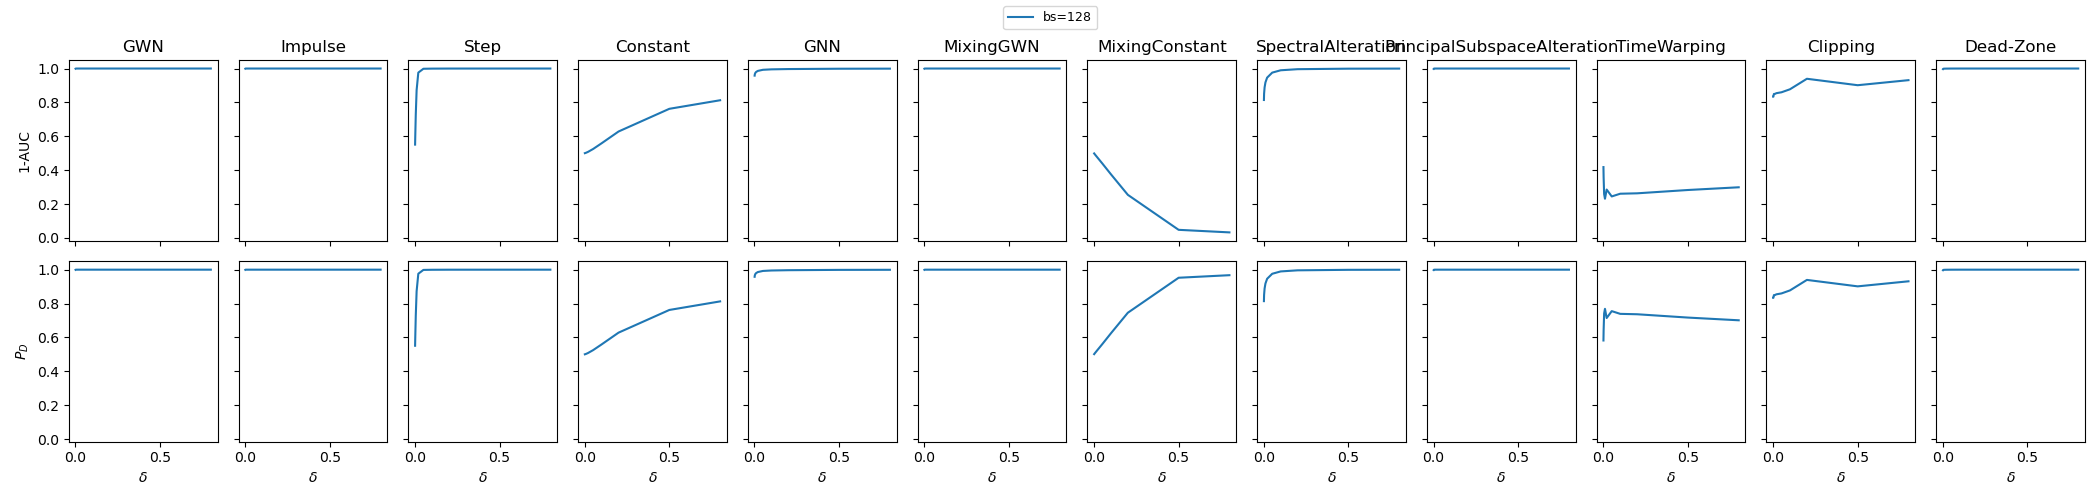

In [181]:
min_delta_ae = 1e-8
data_NN = results_NN.loc[:, m, mode, orthogonal, seed_mat, seed_train, opt, :, min_delta_ae]
plot_performance(data_NN, [bs_nn], 'bs')

# TSOC

In [88]:
def load_tsoc_based_results(detector_mode, trained_models):
    index = pd.MultiIndex.from_product(
    [delta_list, m_list, mode_list, ort_list, seed_mat_list, seed_train_list, opt_list, bs_list, alpha_list, min_delta_list],
      names=['delta', 'm', 'mode', 'ort', 'seedmat', 'seedtrain', 'opt', 'bs', 'alpha', 'mind'])

    results = pd.DataFrame(index=index, columns=anomalies_labels, dtype=np.float64)
    results.columns.name = 'anomalies'
    for delta in delta_list:
        for alpha in alpha_list:
            for trained_model in trained_models[alpha]:
                params = parse_neural_parameters(trained_model, 'TSOC')
                # if not params['seedmat'] == 88219:
                #     continue
                trained_model = f"{trained_model.split('.pth')[0]}"
                if mode == 'rakeness':
                    trained_model = trained_model.split('_')[:-2]
                    trained_model = '_'.join(trained_model)   
                results_subfolder = [file for file in os.listdir(os.path.join(results_folder)) if f'TSOC_{mode}' in file][0]
                results_path = os.path.join(results_folder, results_subfolder, f'alpha={alpha}', detector_mode, 
                                            f'AUC_detector={trained_model}_delta={delta}_seedko={seed_ko}.pkl')
                if os.path.exists(results_path):
                    result = pd.read_pickle(results_path)
                    results.loc[delta, params['m'], params['mode'], params['ort'], params['seedmat'], params['seedtrain'], params['opt'], params['bs'], alpha, params['mind']] = result
    return results

In [89]:
epochs = 1000
trained_models = {}
for alpha in alpha_list:
    trained_models_alpha = os.listdir(os.path.join(f'{models_dir}TSOC', f'alpha={alpha}'))
    trained_models[alpha] = [trained_model for trained_model in trained_models_alpha if f'epochs={epochs}' in trained_model]

## Sparsity

In [97]:
detector_mode = 'sparsity'
results_sparsity = load_tsoc_based_results(detector_mode, trained_models)

In [98]:
results_sparsity

anomalies                                                             GWN  \
delta m  mode     ort  seedmat seedtrain opt  bs  alpha mind                
0.001 48 rakeness True 30808   0         adam 32  0.5   0.00001  0.496338   
                                              64  0.5   0.00001  0.491021   
                                              128 0.5   0.00001  0.487971   
0.002 48 rakeness True 30808   0         adam 32  0.5   0.00001  0.492795   
                                              64  0.5   0.00001  0.484375   
                                              128 0.5   0.00001  0.478440   
0.005 48 rakeness True 30808   0         adam 32  0.5   0.00001  0.483753   
                                              64  0.5   0.00001  0.472126   
                                              128 0.5   0.00001  0.461023   
0.010 48 rakeness True 30808   0         adam 32  0.5   0.00001  0.470303   
                                              64  0.5   0.00001  0.459954   
                                              128 0.5   0.00001  0.447271   
0.020 48 rakeness True 30808   0         adam 32  0.5   0.00001  0.445361   
                                              64  0.5   0.00001  0.444252   
                                              128 0.5   0.00001  0.438432   
0.050 48 rakeness True 30808   0         adam 32  0.5   0.00001  0.388901   
                                              64  0.5   0.00001  0.406350   
                                              128 0.5   0.00001  0.431126   
0.100 48 rakeness True 30808   0         adam 32  0.5   0.00001  0.336303   
                                              64  0.5   0.00001  0.355650   
                                              128 0.5   0.00001  0.418621   
0.200 48 rakeness True 30808   0         adam 32  0.5   0.00001  0.285100   
                                              64  0.5   0.00001  0.292558   
                                              128 0.5   0.00001  0.390041   
0.500 48 rakeness True 30808   0         adam 32  0.5   0.00001  0.234135   
                                              64  0.5   0.00001  0.231866   
                                              128 0.5   0.00001  0.346132   
0.800 48 rakeness True 30808   0         adam 32  0.5   0.00001  0.226646   
                                              64  0.5   0.00001  0.214457   
                                              128 0.5   0.00001  0.323067   

anomalies                                                         Impulse  \
delta m  mode     ort  seedmat seedtrain opt  bs  alpha mind                
0.001 48 rakeness True 30808   0         adam 32  0.5   0.00001  0.498711   
                                              64  0.5   0.00001  0.495827   
                                              128 0.5   0.00001  0.492280   
0.002 48 rakeness True 30808   0         adam 32  0.5   0.00001  0.497620   
                                              64  0.5   0.00001  0.492760   
                                              128 0.5   0.00001  0.486603   
0.005 48 rakeness True 30808   0         adam 32  0.5   0.00001  0.494507   
                                              64  0.5   0.00001  0.484645   
                                              128 0.5   0.00001  0.474401   
0.010 48 rakeness True 30808   0         adam 32  0.5   0.00001  0.490498   
                                              64  0.5   0.00001  0.473669   
                                              128 0.5   0.00001  0.458638   
0.020 48 rakeness True 30808   0         adam 32  0.5   0.00001  0.482594   
                                              64  0.5   0.00001  0.457001   
                                              128 0.5   0.00001  0.435641   
0.050 48 rakeness True 30808   0         adam 32  0.5   0.00001  0.450581   
                                              64  0.5   0.00001  0.418576   
                                              128 0.5   0.00001  0.40658

In [99]:
(1-results_sparsity).style.background_gradient(cmap=cmap_auc, vmin=0, vmax=1)

In [100]:
results_sparsity_PD = 0.5 + np.abs(results_sparsity-0.5)
results_sparsity_PD['mean'] = results_sparsity_PD.mean(axis=1)
results_sparsity_PD.style.background_gradient(cmap=cmap_pd, vmin=0.5, vmax=1)

In [101]:
alpha = 0.5
results_sparsity_avg = results_sparsity_PD.xs(alpha, level='alpha').groupby('bs').mean()
bs_sparsity = results_sparsity_avg['mean'].idxmax()
print(f'Best batch size = {bs_sparsity}')
results_sparsity_avg.style.background_gradient(cmap=cmap_pd, vmin=0.5, vmax=1)

Best batch size = 32


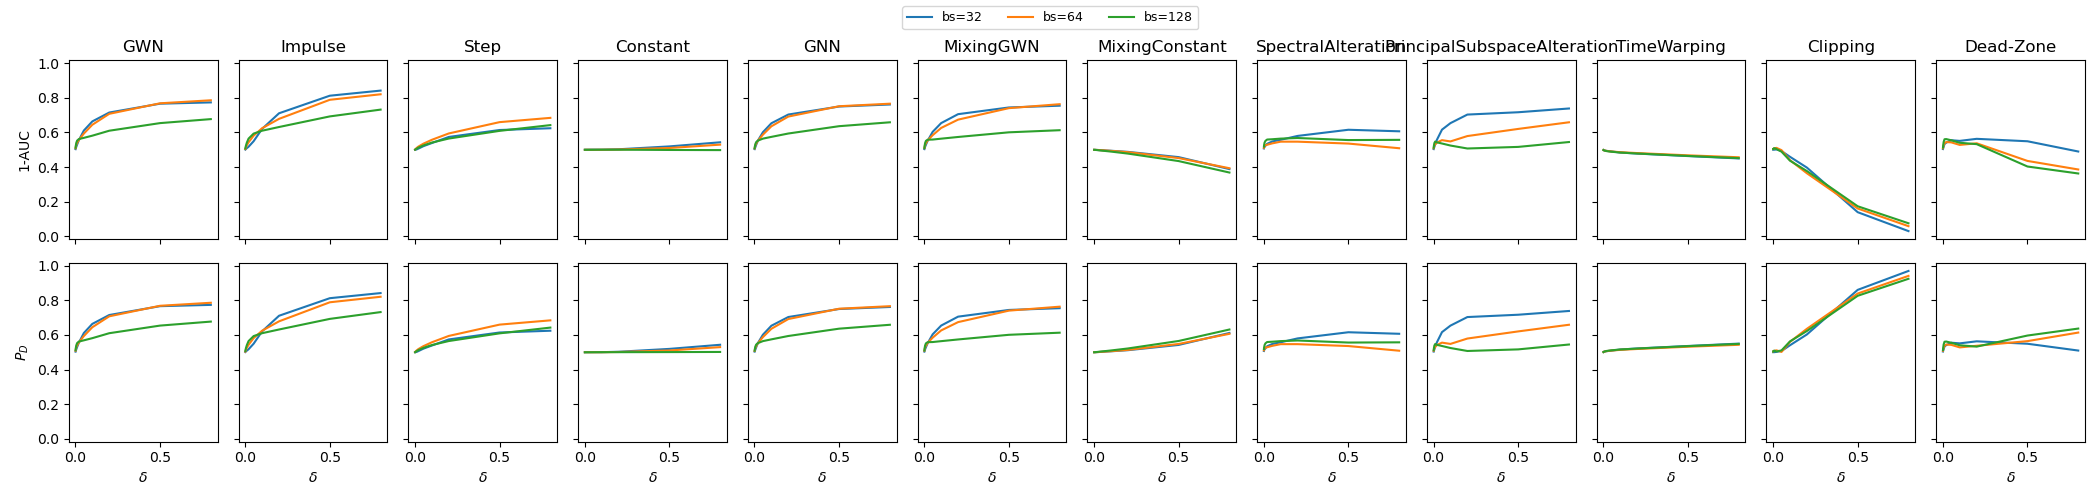

In [102]:
data_sparsity= results_sparsity.loc[:, m, mode, orthogonal, seed_mat, seed_train, opt, :, alpha, min_delta]
plot_performance(data_sparsity, bs_list, 'bs')

## Sparsity threshold

In [103]:
detector_mode = 'sparsity-threshold'
results_sparsity_th = load_tsoc_based_results(detector_mode, trained_models)

In [104]:
(1-results_sparsity_th).style.background_gradient(cmap=cmap_auc, vmin=0, vmax=1)

In [105]:
results_sparsity_th_PD = 0.5 + np.abs(results_sparsity_th-0.5)
results_sparsity_th_PD['mean'] = results_sparsity_th_PD.mean(axis=1)
results_sparsity_th_PD.style.background_gradient(cmap=cmap_pd, vmin=0.5, vmax=1)

In [106]:
alpha = 0.5
results_sparsity_th_avg = results_sparsity_th_PD.xs(alpha, level='alpha').groupby('bs').mean()
bs_sparsity_th = results_sparsity_th_avg['mean'].idxmax()
print(f'Best batch size = {bs_sparsity_th}')
results_sparsity_th_avg.style.background_gradient(cmap=cmap_pd, vmin=0.5, vmax=1)

Best batch size = 64


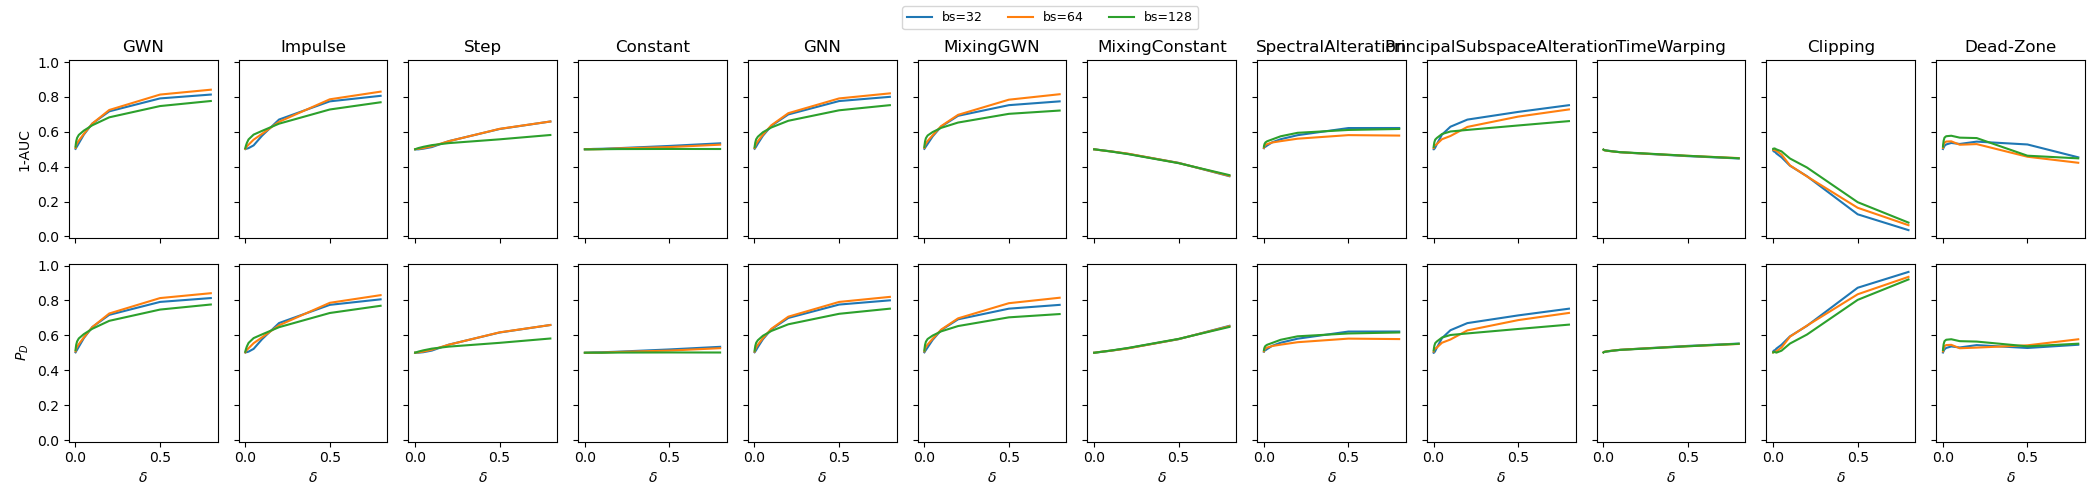

In [107]:
data_sparsity_th = results_sparsity_th.loc[:, m, mode, orthogonal, seed_mat, seed_train, opt, :, alpha, min_delta]
plot_performance(data_sparsity_th, bs_list, 'bs')

## Self-Assessment

In [108]:
detector_mode = 'self-assessment'
results_TSOC = load_tsoc_based_results(detector_mode, trained_models)

In [109]:
(1-results_TSOC).style.background_gradient(cmap=cmap_auc, vmin=0, vmax=1)

In [110]:
results_TSOC_PD = 0.5 + np.abs(results_TSOC-0.5)
results_TSOC_PD['mean'] = results_TSOC_PD.mean(axis=1)
results_TSOC_PD.style.background_gradient(cmap=cmap_pd, vmin=0.5, vmax=1)

In [111]:
alpha = 0.5 
results_TSOC_avg = results_TSOC_PD.xs(alpha, level='alpha').groupby('bs').mean()
bs_tsoc = results_TSOC_avg['mean'].idxmax()
print(f'Best batch size = {bs_tsoc}')
results_TSOC_avg.style.background_gradient(cmap=cmap_pd, vmin=0.5, vmax=1)

Best batch size = 32


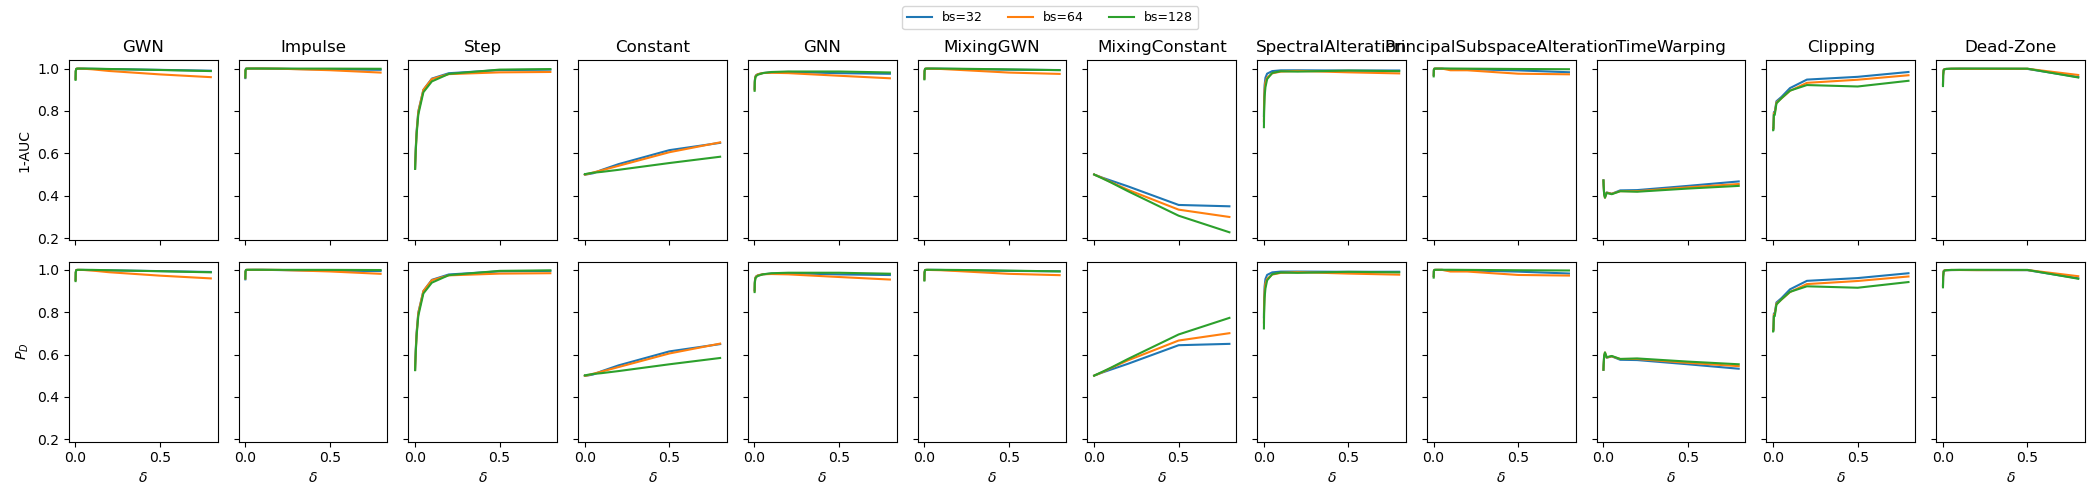

In [112]:
data_TSOC = results_TSOC.loc[:, m, mode, orthogonal, seed_mat, seed_train, opt, :, alpha, min_delta]
plot_performance(data_TSOC, bs_list, 'bs')

In [113]:
batch_size = 128
results_TSOC_avg = results_TSOC_PD.xs(batch_size, level='bs').groupby('alpha').mean()
alpha_tsoc = results_TSOC_avg['mean'].idxmax()
print(f'Best alpha = {alpha_tsoc}')
results_TSOC_avg.style.background_gradient(cmap=cmap_pd, vmin=0.5, vmax=1)

Best alpha = 0.4


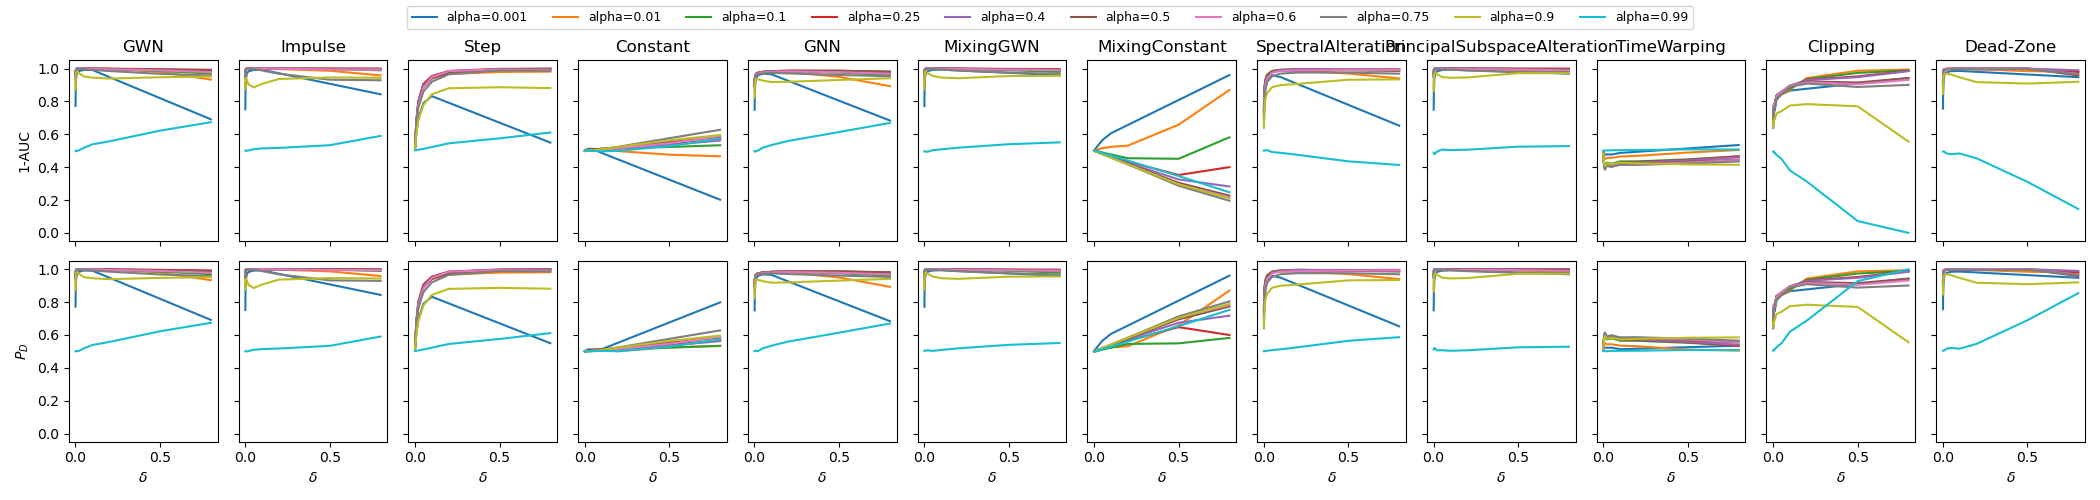

In [114]:
data_TSOC = results_TSOC.loc[:, m, mode, orthogonal, seed_mat, seed_train, opt, batch_size, :, min_delta]
plot_performance(data_TSOC, alpha_list, 'alpha')

## Autoencoder

In [188]:
detector_mode = 'autoencoder'
results_AE = load_tsoc_based_results(detector_mode, trained_models)

TypeError: list indices must be integers or slices, not float

In [ ]:
(1-results_AE).style.background_gradient(cmap=cmap_auc, vmin=0, vmax=1)

In [117]:
results_AE_PD = 0.5 + np.abs(results_AE-0.5)
results_AE_PD['mean'] = results_AE_PD.mean(axis=1)
results_AE_PD.style.background_gradient(cmap=cmap_pd, vmin=0.5, vmax=1)

In [118]:
alpha = 0.5
results_AE_avg = results_AE_PD.xs(alpha, level='alpha').groupby('bs').mean()
bs_ae = results_AE_avg['mean'].idxmax()
print(f'Best batch size = {bs_ae}')
results_AE_avg.style.background_gradient(cmap=cmap_pd, vmin=0.5, vmax=1)

Best batch size = 32


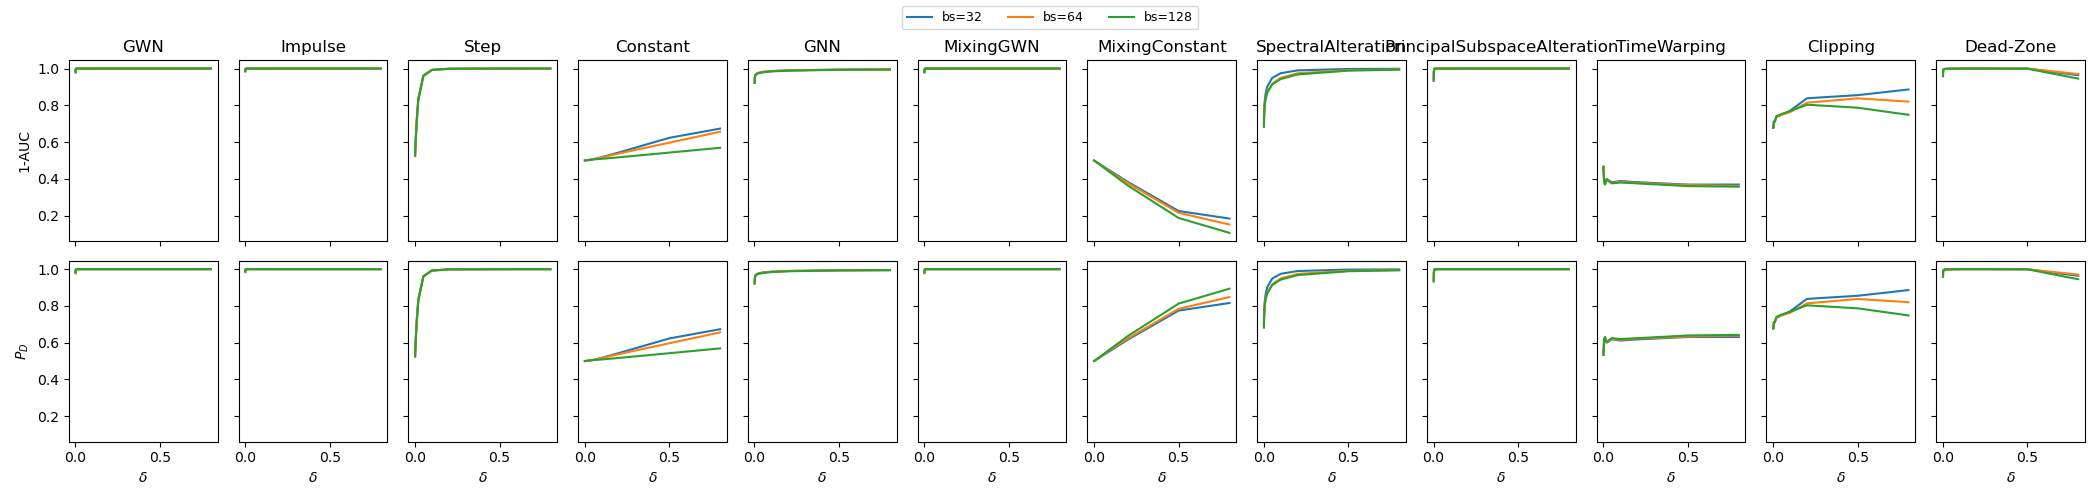

In [119]:
data_AE = results_AE.loc[:, m, mode, orthogonal, seed_mat, seed_train, opt, :, alpha, min_delta]
plot_performance(data_AE, bs_list, 'bs')

## Complement

In [120]:
detector_mode = 'complement'
results_comp = load_tsoc_based_results(detector_mode, trained_models)

In [121]:
(1-results_comp).style.background_gradient(cmap=cmap_auc, vmin=0, vmax=1)

In [122]:
results_comp_PD = 0.5 + np.abs(results_comp-0.5)
results_comp_PD['mean'] = results_comp_PD.mean(axis=1)
results_comp_PD.style.background_gradient(cmap=cmap_pd, vmin=0.5, vmax=1)

In [123]:
alpha = 0.5
results_comp_avg = results_comp_PD.xs(alpha, level='alpha').groupby('bs').mean()
bs_comp = results_comp_avg['mean'].idxmax()
print(f'Best batch size = {bs_comp}')
results_comp_avg.style.background_gradient(cmap=cmap_pd, vmin=0.5, vmax=1)

Best batch size = 64


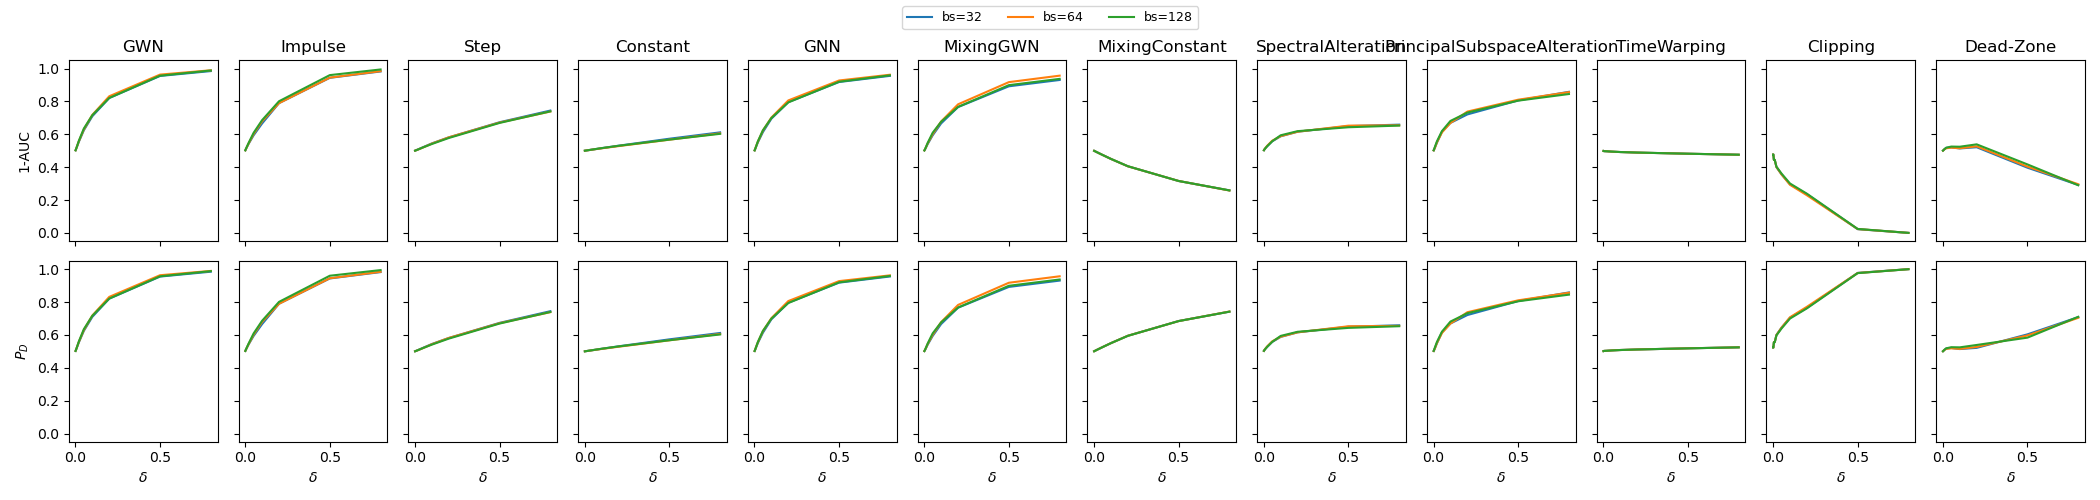

In [124]:
data_comp = results_comp.loc[:, m, mode, orthogonal, seed_mat, seed_train, opt, :, alpha, min_delta]
plot_performance(data_comp, bs_list, 'bs')

## Combined SA and complement

In [125]:
detector_mode = 'self-assessment-complement'
results_sacomp = load_tsoc_based_results(detector_mode, trained_models)

In [126]:
(1-results_sacomp).style.background_gradient(cmap=cmap_auc, vmin=0, vmax=1)

In [127]:
results_sacomp_PD = 0.5 + np.abs(results_sacomp-0.5)
results_sacomp_PD['mean'] = results_sacomp_PD.mean(axis=1)
results_sacomp_PD.style.background_gradient(cmap=cmap_pd, vmin=0.5, vmax=1)

In [128]:
alpha = 0.5
results_sacomp_avg = results_sacomp_PD.xs(alpha, level='alpha').groupby('bs').mean()
bs_sac = results_sacomp_avg['mean'].idxmax()
print(f'Best batch size = {bs_sac}')
results_sacomp_avg.style.background_gradient(cmap=cmap_pd, vmin=0.5, vmax=1)

Best batch size = 128


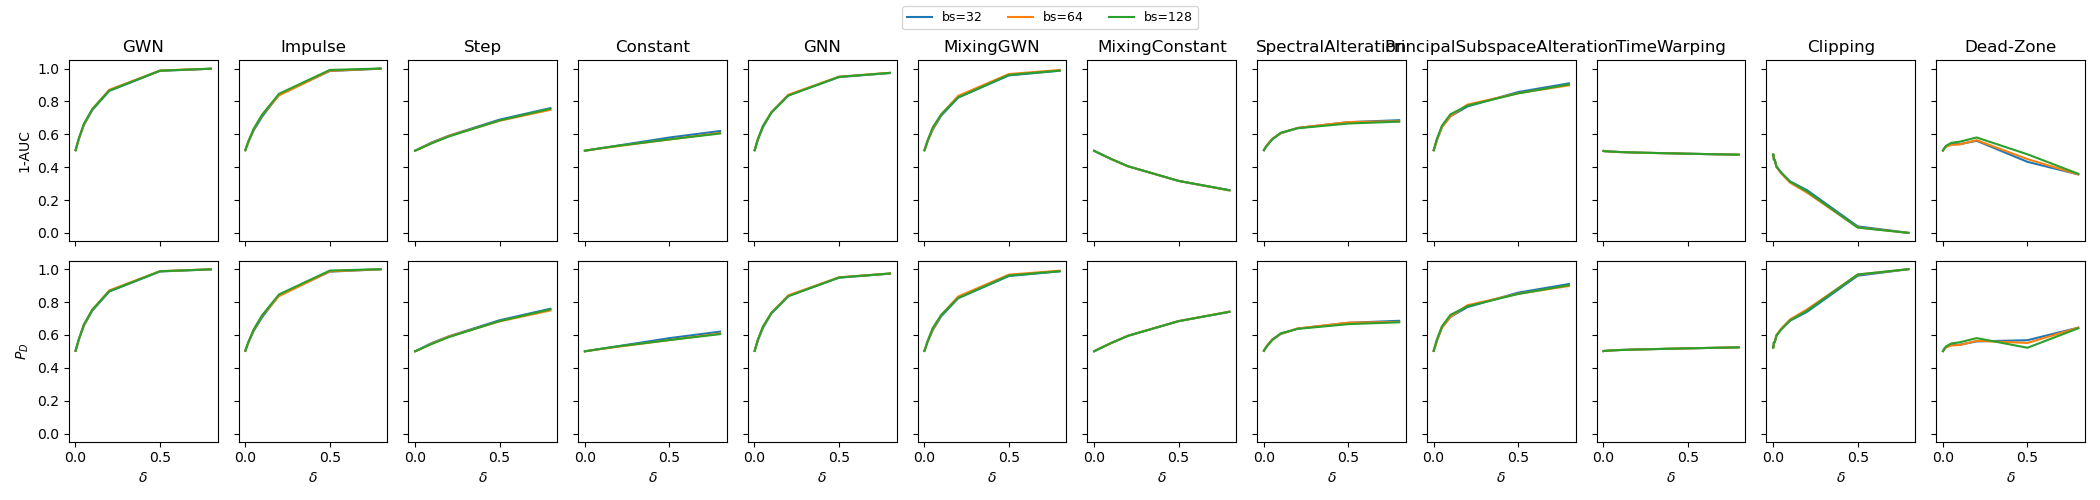

In [129]:
data_sacomp = results_sacomp.loc[:, m, mode, orthogonal, seed_mat, seed_train, opt, :, alpha, min_delta]
plot_performance(data_sacomp, bs_list, 'bs')

# Comparison

In [182]:
detector_labels = [f'IF #est={estimators}', f'LOF #neigh={neighbors}', f'OCSVM nu={nu}',
                    f'SPE k={k_SPE}', f'T2 k={k_T2}', f'AR p={order}',
                      'MD', 
                      f'NN bs={bs_nn}',
                        f'TSOC bs={bs_tsoc}', f'AE bs={bs_ae}',
                          # f'S bs={bs_sparsity}', f'Sth bs={bs_sparsity_th}',
                        f'Comp bs={bs_comp}', f'SA+comp bs={bs_sac}']

In [183]:
# results_final = pd.concat([
#     results_IF_PD.xs(estimators, level='estimators').mean(),
#     results_LOF_PD.xs(neighbors, level='neighbors').mean(),
#     results_OCSVM_PD.xs(nu, level='nu').mean(),
#     results_SPE_PD.xs(k_SPE, level='k').mean(),
#     results_T2_PD.xs(k_T2, level='k').mean(),
#     results_AR_PD.xs(order, level='order').mean(),
#     results_FB_PD.xs(detector, level='detector').mean(),
#     results_TSOC_PD.xs(bs_tsoc, level='bs').mean(),
#     results_AE_PD.xs(bs_ae, level='bs').mean(),
#     results_sparsity_PD.xs(bs_ae, level='bs').mean(),
#     results_sparsity_th_PD.xs(bs_ae, level='bs').mean(),
#     results_comp_PD.xs(bs_ae, level='bs').mean(),
#     results_sacomp_PD.xs(bs_ae, level='bs').mean()
#     ],
#     axis=1,    
#     keys=detector_labels
# )


In [184]:
drop_levels = ['m', 'mode', 'ort', 'seedmat']
alpha = 0.5
results_final = pd.concat([
    results_IF_PD.xs(estimators, level='estimators').droplevel(drop_levels).stack(),
    results_LOF_PD.xs(neighbors, level='neighbors').droplevel(drop_levels).stack(),
    results_OCSVM_PD.xs(nu, level='nu').droplevel(drop_levels).stack(),
    results_SPE_PD.xs(k_SPE, level='k').droplevel(drop_levels).stack(),
    results_T2_PD.xs(k_T2, level='k').droplevel(drop_levels).stack(),
    results_AR_PD.xs(order, level='order').droplevel(drop_levels).stack(),
    results_FB_PD.xs(detector, level='detector').droplevel(drop_levels).stack(),
    results_NN_PD.xs(bs_nn, level='bs').droplevel([*drop_levels, 'seedtrain', 'opt', 'mind']).stack(),
    results_TSOC_PD.xs(bs_tsoc, level='bs').xs(alpha, level='alpha').droplevel([*drop_levels, 'seedtrain', 'opt', 'mind']).stack(),
    results_AE_PD.xs(bs_ae, level='bs').xs(alpha, level='alpha').droplevel([*drop_levels, 'seedtrain', 'opt', 'mind']).stack(),
    # results_sparsity_PD.xs(bs_ae, level='bs').xs(alpha, level='alpha').droplevel([*drop_levels, 'seedtrain', 'opt', 'mind']).stack(),
    # results_sparsity_th_PD.xs(bs_ae, level='bs').xs(alpha, level='alpha').droplevel([*drop_levels, 'seedtrain', 'opt', 'mind']).stack(),
    results_comp_PD.xs(bs_ae, level='bs').xs(alpha, level='alpha').droplevel([*drop_levels, 'seedtrain', 'opt', 'mind']).stack(),
    results_sacomp_PD.xs(bs_ae, level='bs').xs(alpha, level='alpha').droplevel([*drop_levels, 'seedtrain', 'opt', 'mind']).stack(),
    ],
      axis=1,
    keys=detector_labels
)


In [185]:
results_final.style.background_gradient(cmap=cmap_pd, vmin=0.5, vmax=1)

In [186]:
results_final.groupby('anomalies').mean().style.background_gradient(cmap=cmap_pd, vmin=0.5, vmax=1)

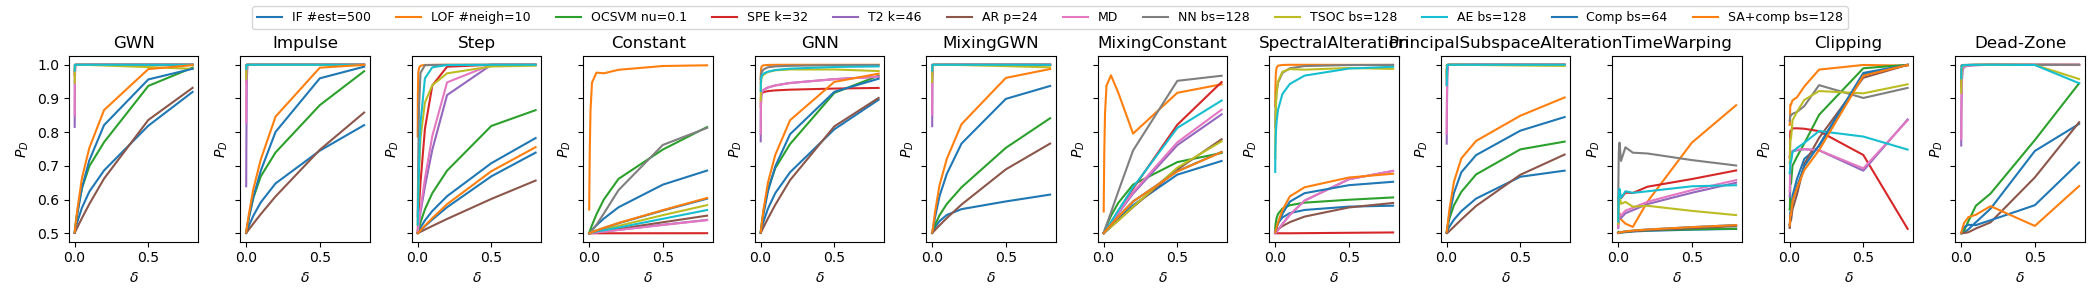

In [187]:
handles = []
labels = []
fig, ax = plt.subplots(1, len(anomalies_labels), figsize=(21, 3), sharey=True, sharex=True)
for detector_label in detector_labels:
    for j, anomaly in enumerate(anomalies_labels):
        data_ = results_final.xs(anomaly, level='anomalies')[detector_label]
        handle, = ax[j].plot(data_.index, data_.values)
        ax[j].set(title=anomaly, xlabel='$\delta$', ylabel='$P_D$')
        if j == 0:
            handles.append(handle)
            labels.append(detector_label)

fig.legend(
    handles=handles,
    labels=labels,
    loc='upper center',
    ncol=len(detector_labels),
    fontsize=9,
    bbox_to_anchor=(0.5, 1.0),  # Adjust position relative to the figure
)
fig.tight_layout(rect=[0, 0, 1, 0.93])


# <span style="color: red;"> Issues </span>
<!-- - Which training hyperparameters should I use: ``optimizer``, ``batch_size``, ``learning_rate``?
- Will we use callback functions? -->
<!-- - Use training data from JETCAS -->
- The performance measured in terms of $AUC$ require score inversion for specific anomalie -> use $P_D$
- The performance of TSOC-based detector are decreasing with delta -> **Analyze** the behaviour in a specific case
- The choice of the TSOC hyper-parameters depends on the task: anomaly detection / reconstruction -> Fix them based on reconstruction performance
- Train TSOC with noise?

# <span style="color: red;"> TODO </span>
<!-- - Which training hyperparameters should I use: ``optimizer``, ``batch_size``, ``learning_rate``?
- Will we use callback functions? -->
<!-- - Use training data from JETCAS -->
- Use an autoencoder with the same architecture as TSOC?
- Analyze the scores for GWN w.r.t. $\delta$
- Discard AR, train OCSVM with a polynomial kernel.